In [1]:
import numpy as np
import tensorflow as tf
import random as rn
import os
import sys
from functools import reduce
from tensorflow.keras.optimizers import SGD
from sklearn.linear_model import LogisticRegression

import pandas as pd
import pyarrow.parquet as pq
import csv
import glob
from keras import models
from keras import layers
from keras import Input
import keras 
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from collections import Counter
from keras.callbacks import History
from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import Precision
# import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline      # for warping
from transforms3d.axangles import axangle2mat  # for rotation
import keras_tuner as kt
from matplotlib import pyplot
import xlsxwriter
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
np.set_printoptions(threshold=sys.maxsize)


In [2]:
# ## 1. Jittering

# #### Hyperparameters :  sigma = standard devitation (STD) of the noise
def DA_Jitter(X, sigma=0.01):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X + myNoise


# ## 2. Scaling

# #### Hyperparameters :  sigma = STD of the zoom-in/out factor
def DA_Scaling(X, sigma=0.5):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1, X.shape[1]))  # shape=(1,3)
    myNoise = np.matmul(np.ones((X.shape[0], 1)), scalingFactor)
    return X * myNoise


# ## 3. Magnitude Warping

# #### Hyperparameters :  sigma = STD of the random knots for generating curves
#
# #### knot = # of knots for the random curves (complexity of the curves)

# "Scaling" can be considered as "applying constant noise to the entire samples" whereas "Jittering" can be considered as "applying different noise to each sample".

# "Magnitude Warping" can be considered as "applying smoothly-varing noise to the entire samples"


## This example using cubic splice is not the best approach to generate random curves.
## You can use other aprroaches, e.g., Gaussian process regression, Bezier curve, etc.
def GenerateRandomCurves(X, sigma=0.2, knot=4):
    xx = (np.ones((X.shape[1], 1)) * (np.arange(0, X.shape[0], (X.shape[0] - 1) / (knot + 1)))).transpose()
    yy = np.random.normal(loc=1.0, scale=sigma, size=(knot + 2, X.shape[1]))
    x_range = np.arange(X.shape[0])
    random_curves = []
    for i in range(X.shape[-1]):
        cs = CubicSpline(xx[:, i], yy[:, i])
        random_curves.append(cs(x_range))
    return np.array(random_curves).transpose()


def DA_MagWarp(X, sigma=0.2):
    return X * GenerateRandomCurves(X, sigma)


# ## 4. Time Warping

# #### Hyperparameters :  sigma = STD of the random knots for generating curves
#
# #### knot = # of knots for the random curves (complexity of the curves)

def DistortTimesteps(X, sigma=0.2):
    tt = GenerateRandomCurves(X, sigma)  # Regard these samples aroun 1 as time intervals
    tt_cum = np.cumsum(tt, axis=0)  # Add intervals to make a cumulative graph
    # Make the last value to have X.shape[0]
    for i in range(X.shape[-1]):
        t_scale = (X.shape[0] - 1) / tt_cum[-1, i]
        tt_cum[:, i] = tt_cum[:, i] * t_scale
    return tt_cum


def DA_TimeWarp(X, sigma=0.2):
    tt_new = DistortTimesteps(X, sigma)
    X_new = np.zeros(X.shape)
    x_range = np.arange(X.shape[0])
    for i in range(X.shape[-1]):
        X_new[:, i] = np.interp(x_range, tt_new[:, i], X[:, i])
    return X_new


# ## 5. Permutation

# #### Hyperparameters :  nPerm = # of segments to permute
# #### minSegLength = allowable minimum length for each segment

def DA_Permutation(X, nPerm=4, minSegLength=10):
    X_new = np.zeros(X.shape)
    idx = np.random.permutation(nPerm)
    bWhile = True
    while bWhile:
        segs = np.zeros(nPerm + 1, dtype=int)
        segs[1:-1] = np.sort(np.random.randint(minSegLength, X.shape[0] - minSegLength, nPerm - 1))
        segs[-1] = X.shape[0]
        if np.min(segs[1:] - segs[0:-1]) > minSegLength:
            bWhile = False
    pp = 0
    for ii in range(nPerm):
        x_temp = X[segs[idx[ii]]:segs[idx[ii] + 1], :]
        X_new[pp:pp + len(x_temp), :] = x_temp
        pp += len(x_temp)
    return X_new


In [3]:
def augment_data(train_set, train_label, function):

    train_set_one = train_set
#     START AUGMENTING
    LABEL = []
    # select random indices
    number_of_rows = int(train_set_one.shape[0] * 0.5)

#     random indices has to be the same for every dimension so that the label can be accurate
    random_indices = np.sort(np.random.choice(train_set_one.shape[0]-1, size=int(number_of_rows), replace=False))
    train_set_one = train_set_one[random_indices,:]
    
    
    train_set_one = train_set_one.transpose()
    if function == 'scale':
        train_set_one = DA_Scaling(train_set_one)
    elif function == 'jitter':
        train_set_one = DA_Jitter(train_set_one)
    elif function == 'magWarp':
        train_set_one = DA_MagWarp(train_set_one)
    elif function == 'timeWarp':
        train_set_one = DA_TimeWarp(train_set_one)
    elif function == 'rotation':
        train_set_one = DA_Rotation(train_set_one)
    elif function == 'permutation':
        train_set_one = DA_Permutation(train_set_one)
    else:
        print("Error no augmentation function")
        return -1
    train_set_one = train_set_one.transpose()
        
    
    # take the label and add them as the label for the new augmented data
    LABEL = np.array(train_label[random_indices])
#     we have ARR which is of shape (6, row, col) with the augmented data
#     and train_set which is of shape (6, row, col) with the non augmented data
    
    train_set_augmented = np.concatenate((train_set, train_set_one), axis = 0)
    print(train_set[0,0])
    print(train_set_one[0,0])
    train_label = np.array(train_label)
    label_set_augmented = np.concatenate((train_label, LABEL))
    
    return train_set_augmented, label_set_augmented



In [4]:
def model_network(learning_rate):
    seed_value = 34567892
    os.environ['PYTHONHASHSEED']=str(seed_value)
    tf.random.set_seed(seed_value)

    
    model = Sequential()
    model.add(Input(shape=(2400,)))
    model.add(layers.BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
#     opt = SGD(learning_rate=0.0001,momentum=0.4)
    opt = Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', Recall(), Precision()])
    return model


2022-06-08 19:06:05.649100: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


evaluate original:  [0.7328324317932129, 0.7610936760902405, 0.8918918967247009, 0.6869888305664062]


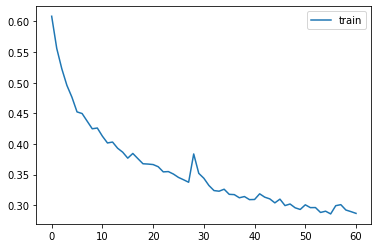

jitter
51.478270616630205
51.49522372161494
evaluate augmented :  jitter [1.076453685760498, 0.7745405435562134, 0.8484556078910828, 0.7175509929656982]


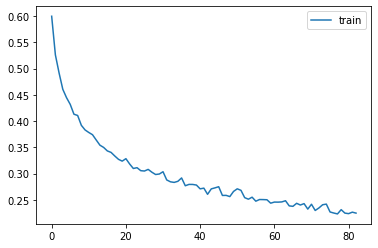

51.478270616630205
51.472995021394766
evaluate augmented :  jitter [0.6951156258583069, 0.7745405435562134, 0.837837815284729, 0.721529483795166]


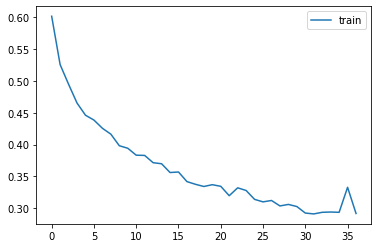

51.478270616630205
51.47559073053882
evaluate augmented :  jitter [1.0220246315002441, 0.7794710993766785, 0.8416988253593445, 0.7266666889190674]


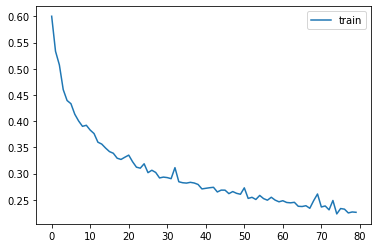

51.478270616630205
51.47761656465535
evaluate augmented :  jitter [0.9647300243377686, 0.7561631798744202, 0.8832046389579773, 0.6838564872741699]


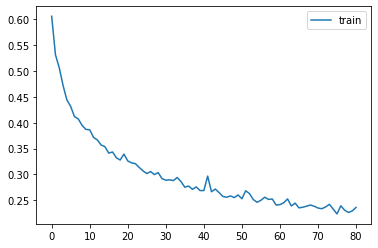

51.478270616630205
51.46476688361873
evaluate augmented :  jitter [0.7920639514923096, 0.7839533686637878, 0.8021235466003418, 0.75]


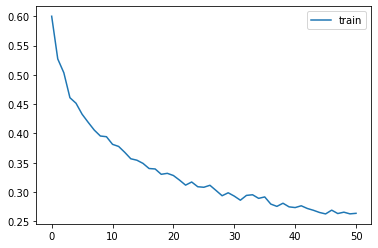

51.478270616630205
46.461293336410336
evaluate augmented :  jitter [0.8285285234451294, 0.7691618204116821, 0.8484556078910828, 0.710590124130249]


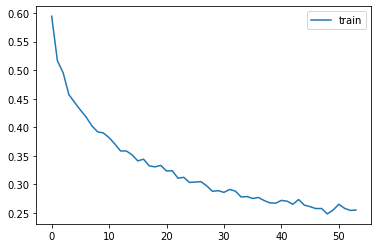

51.478270616630205
94.47789132248597
evaluate augmented :  jitter [0.9613734483718872, 0.7754369974136353, 0.8581081032752991, 0.7152051329612732]


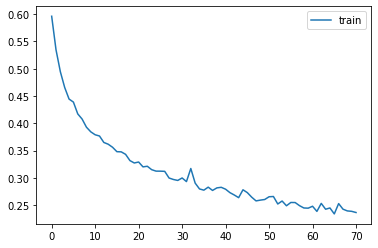

51.478270616630205
52.17135281781682
evaluate augmented :  jitter [1.0285876989364624, 0.7848498225212097, 0.8194980621337891, 0.7434325814247131]


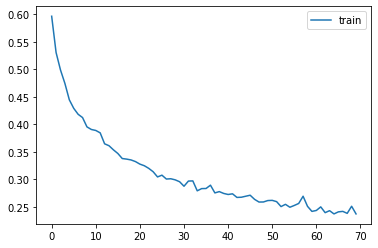

51.478270616630205
51.4761775168313
evaluate augmented :  jitter [0.9591927528381348, 0.7740923166275024, 0.8725868463516235, 0.7084639668464661]


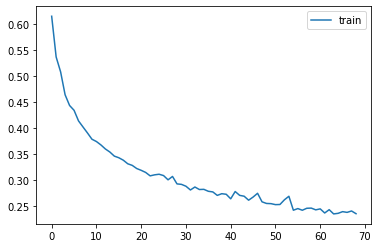

51.478270616630205
46.47091001506217
evaluate augmented :  jitter [0.8322170376777649, 0.7794710993766785, 0.8330115675926208, 0.730118453502655]


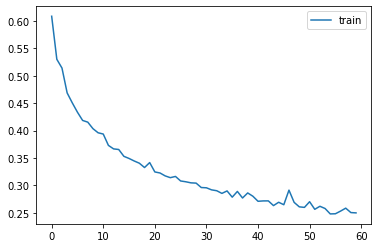

[0.7745405435562134, 0.7745405435562134, 0.7794710993766785, 0.7561631798744202, 0.7839533686637878, 0.7691618204116821, 0.7754369974136353, 0.7848498225212097, 0.7740923166275024, 0.7794710993766785]
[0.8484556078910828, 0.837837815284729, 0.8416988253593445, 0.8832046389579773, 0.8021235466003418, 0.8484556078910828, 0.8581081032752991, 0.8194980621337891, 0.8725868463516235, 0.8330115675926208]
[0.7175509929656982, 0.721529483795166, 0.7266666889190674, 0.6838564872741699, 0.75, 0.710590124130249, 0.7152051329612732, 0.7434325814247131, 0.7084639668464661, 0.730118453502655]
mean: 0.7751680791378022 -- std: (+/- 0.00779248328247332
scale
51.478270616630205
21.137783663300585
evaluate augmented :  scale [0.8354598879814148, 0.7794710993766785, 0.8696911334991455, 0.7162162065505981]


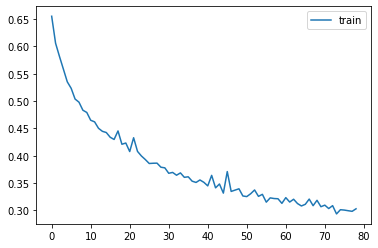

51.478270616630205
23.627237607742494
evaluate augmented :  scale [0.7276638150215149, 0.783056914806366, 0.8793436288833618, 0.717322826385498]


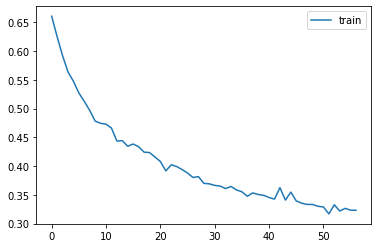

51.478270616630205
53.861197162828375
evaluate augmented :  scale [0.8047575354576111, 0.7920215129852295, 0.8629343509674072, 0.7351973652839661]


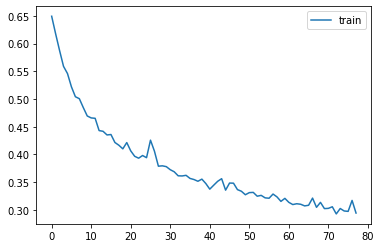

51.478270616630205
156.34575292775304
evaluate augmented :  scale [0.84392911195755, 0.7740923166275024, 0.799227774143219, 0.7366548180580139]


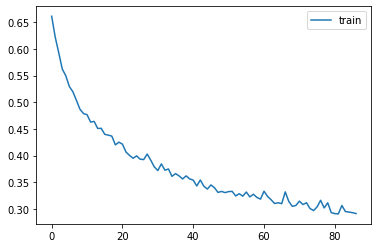

51.478270616630205
45.43148768619738
evaluate augmented :  scale [0.7586761713027954, 0.7888839244842529, 0.876447856426239, 0.7258193492889404]


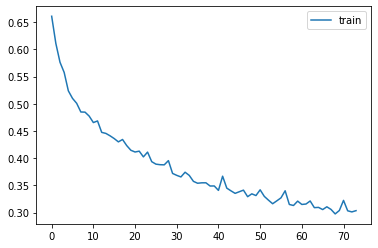

51.478270616630205
46.302277343641386
evaluate augmented :  scale [0.7425549030303955, 0.7982967495918274, 0.8899613618850708, 0.7329093813896179]


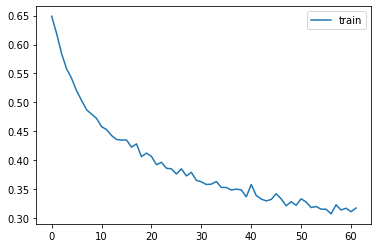

51.478270616630205
53.500725823676675
evaluate augmented :  scale [0.629936158657074, 0.764231264591217, 0.9083011746406555, 0.6858600378036499]


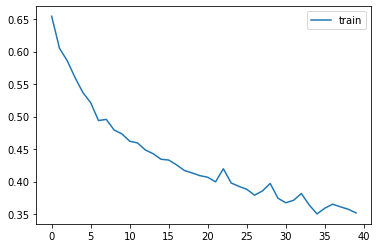

51.478270616630205
46.6184241486102
evaluate augmented :  scale [0.8110798001289368, 0.7736440896987915, 0.8803088665008545, 0.7053364515304565]


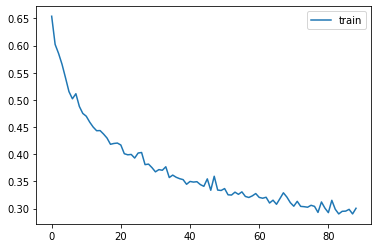

51.478270616630205
37.04984031751888
evaluate augmented :  scale [0.7922514081001282, 0.7758852243423462, 0.8928571343421936, 0.7039573788642883]


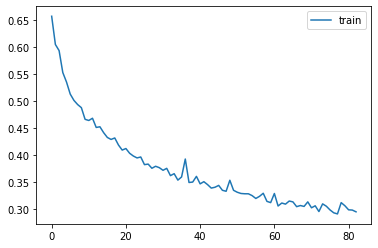

51.478270616630205
49.474319228456494
evaluate augmented :  scale [0.7645317316055298, 0.7839533686637878, 0.9160231947898865, 0.7061011791229248]


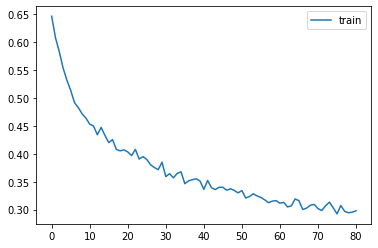

[0.7794710993766785, 0.783056914806366, 0.7920215129852295, 0.7740923166275024, 0.7888839244842529, 0.7982967495918274, 0.764231264591217, 0.7736440896987915, 0.7758852243423462, 0.7839533686637878]
[0.8696911334991455, 0.8793436288833618, 0.8629343509674072, 0.799227774143219, 0.876447856426239, 0.8899613618850708, 0.9083011746406555, 0.8803088665008545, 0.8928571343421936, 0.9160231947898865]
[0.7162162065505981, 0.717322826385498, 0.7351973652839661, 0.7366548180580139, 0.7258193492889404, 0.7329093813896179, 0.6858600378036499, 0.7053364515304565, 0.7039573788642883, 0.7061011791229248]
mean: 0.7813536465168 -- std: (+/- 0.00951853269618699
magWarp
51.478270616630205
59.85336201945134
evaluate augmented :  magWarp [0.864320695400238, 0.7870910167694092, 0.8889961242675781, 0.7189695835113525]


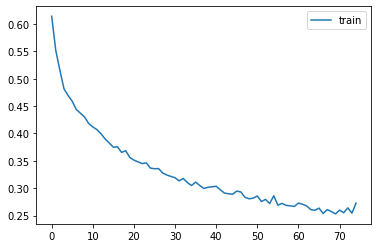

51.478270616630205
41.87087858232884
evaluate augmented :  magWarp [1.0253052711486816, 0.7839533686637878, 0.8870656490325928, 0.7157320976257324]


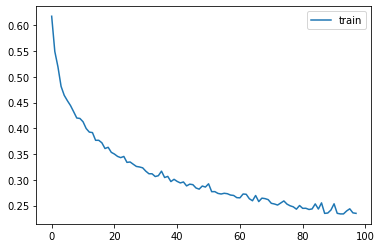

51.478270616630205
65.2821604640483
evaluate augmented :  magWarp [0.9879205822944641, 0.7803675532341003, 0.8851351141929626, 0.7119565010070801]


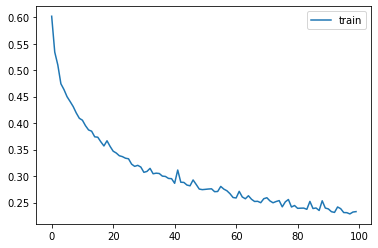

51.478270616630205
53.53442635579446
evaluate augmented :  magWarp [0.714273989200592, 0.7785746455192566, 0.8204632997512817, 0.734024167060852]


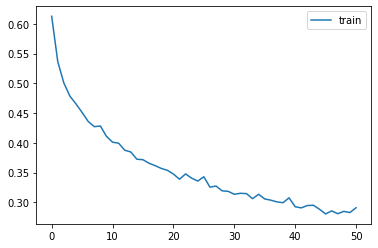

51.478270616630205
32.73414483102214
evaluate augmented :  magWarp [0.8813788890838623, 0.7790228724479675, 0.834942102432251, 0.7287278771400452]


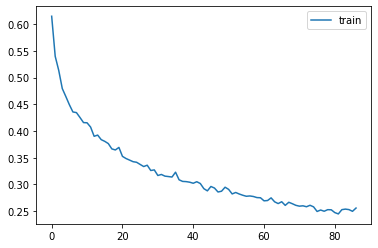

51.478270616630205
49.890894504517576
evaluate augmented :  magWarp [0.7473189234733582, 0.7799193263053894, 0.8812741041183472, 0.7127244472503662]


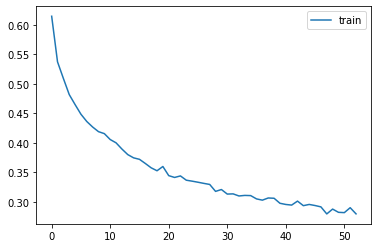

51.478270616630205
50.21582836343836
evaluate augmented :  magWarp [0.7242871522903442, 0.7911250591278076, 0.8793436288833618, 0.7276358008384705]


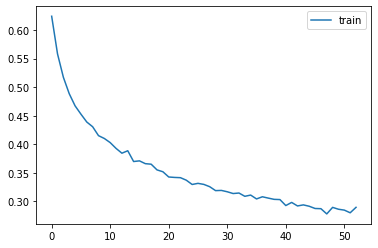

51.478270616630205
49.60161171818373
evaluate augmented :  magWarp [0.7615311741828918, 0.7785746455192566, 0.8996139168739319, 0.704992413520813]


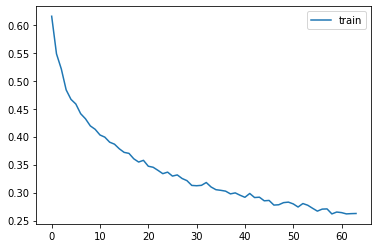

51.478270616630205
56.16130183554097
evaluate augmented :  magWarp [0.7920145988464355, 0.7915732860565186, 0.8996139168739319, 0.7208043336868286]


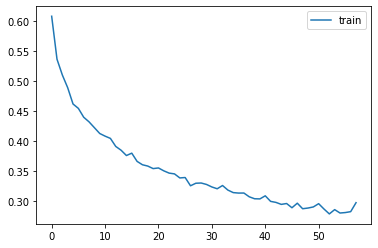

51.478270616630205
52.20410572650593
evaluate augmented :  magWarp [0.9630150198936462, 0.7933661937713623, 0.8320463299751282, 0.7502175569534302]


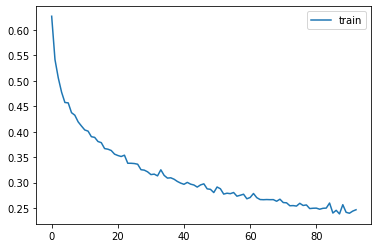

[0.7870910167694092, 0.7839533686637878, 0.7803675532341003, 0.7785746455192566, 0.7790228724479675, 0.7799193263053894, 0.7911250591278076, 0.7785746455192566, 0.7915732860565186, 0.7933661937713623]
[0.8889961242675781, 0.8870656490325928, 0.8851351141929626, 0.8204632997512817, 0.834942102432251, 0.8812741041183472, 0.8793436288833618, 0.8996139168739319, 0.8996139168739319, 0.8320463299751282]
[0.7189695835113525, 0.7157320976257324, 0.7119565010070801, 0.734024167060852, 0.7287278771400452, 0.7127244472503662, 0.7276358008384705, 0.704992413520813, 0.7208043336868286, 0.7502175569534302]
mean: 0.7843567967414856 -- std: (+/- 0.005635756768135802
timeWarp
51.478270616630205
51.478270616630205
evaluate augmented :  timeWarp [0.8745213747024536, 0.7687135934829712, 0.8899613618850708, 0.6963745951652527]


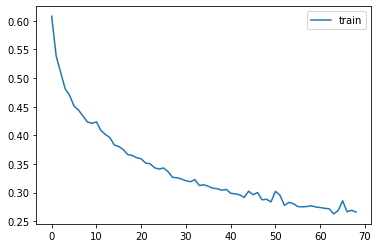

51.478270616630205
51.478270616630205
evaluate augmented :  timeWarp [0.9679754376411438, 0.7785746455192566, 0.8590733408927917, 0.7189014554023743]


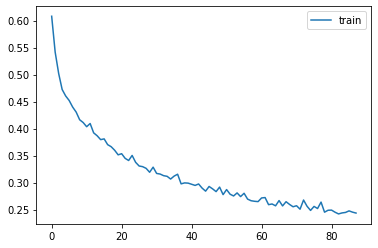

51.478270616630205
51.478270616630205
evaluate augmented :  timeWarp [1.0509287118911743, 0.7781264185905457, 0.8117760419845581, 0.737072765827179]


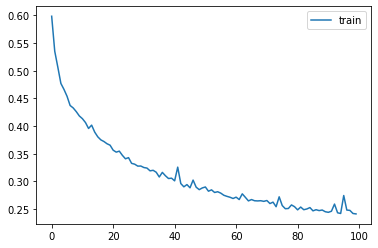

51.478270616630205
46.45108937047337
evaluate augmented :  timeWarp [0.9063170552253723, 0.7776781916618347, 0.8484556078910828, 0.7216748595237732]


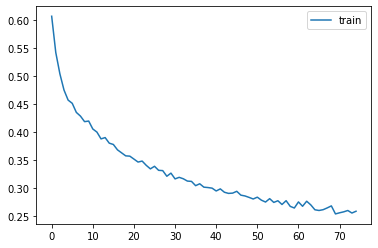

51.478270616630205
51.478270616630205
evaluate augmented :  timeWarp [0.7500259876251221, 0.7915732860565186, 0.8774131536483765, 0.7289494872093201]


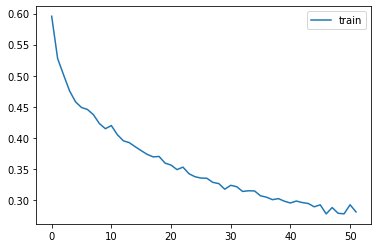

51.478270616630205
51.478270616630205
evaluate augmented :  timeWarp [0.909626305103302, 0.7758852243423462, 0.8513513803482056, 0.7182410359382629]


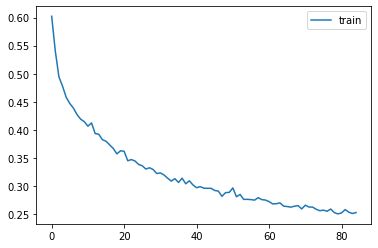

51.478270616630205
51.478270616630205
evaluate augmented :  timeWarp [0.8716210722923279, 0.7906768321990967, 0.8667953610420227, 0.7318663597106934]


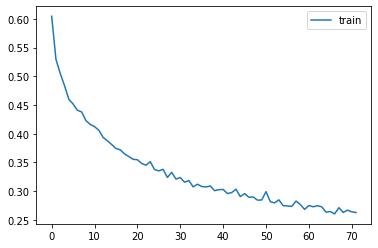

51.478270616630205
52.184146876088576
evaluate augmented :  timeWarp [0.8613079190254211, 0.7839533686637878, 0.8638995885848999, 0.7241100072860718]


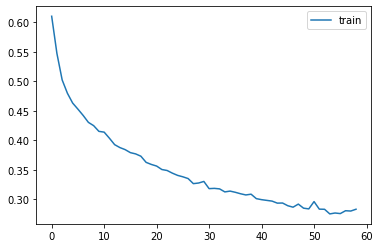

51.478270616630205
46.45108937047337
evaluate augmented :  timeWarp [0.898351788520813, 0.7772299647331238, 0.8571428656578064, 0.7178658246994019]


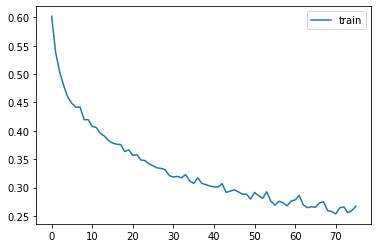

51.478270616630205
51.478270616630205
evaluate augmented :  timeWarp [0.8035316467285156, 0.7861945033073425, 0.8474903702735901, 0.7335004210472107]


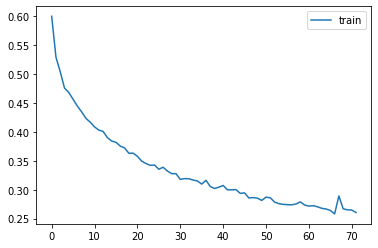

[0.7687135934829712, 0.7785746455192566, 0.7781264185905457, 0.7776781916618347, 0.7915732860565186, 0.7758852243423462, 0.7906768321990967, 0.7839533686637878, 0.7772299647331238, 0.7861945033073425]
[0.8899613618850708, 0.8590733408927917, 0.8117760419845581, 0.8484556078910828, 0.8774131536483765, 0.8513513803482056, 0.8667953610420227, 0.8638995885848999, 0.8571428656578064, 0.8474903702735901]
[0.6963745951652527, 0.7189014554023743, 0.737072765827179, 0.7216748595237732, 0.7289494872093201, 0.7182410359382629, 0.7318663597106934, 0.7241100072860718, 0.7178658246994019, 0.7335004210472107]
mean: 0.7808606028556824 -- std: (+/- 0.00676350871242934
permutation
51.478270616630205
63.7008388877258
evaluate augmented :  permutation [0.8437284827232361, 0.7902286052703857, 0.8889961242675781, 0.7229199409484863]


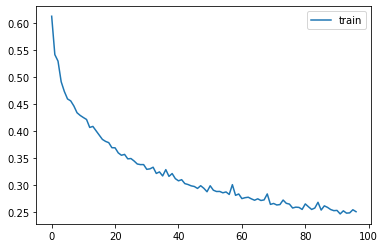

51.478270616630205
86.00474595352638
evaluate augmented :  permutation [0.9044622778892517, 0.7799193263053894, 0.8079150319099426, 0.741364061832428]


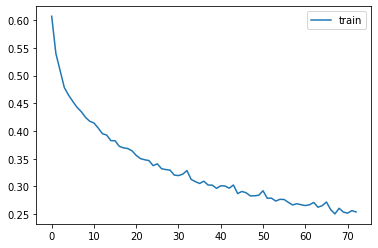

51.478270616630205
68.07723704794161
evaluate augmented :  permutation [0.8663467168807983, 0.7929179668426514, 0.8532818555831909, 0.7403684854507446]


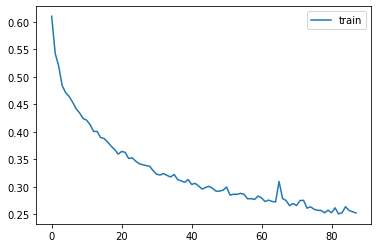

51.478270616630205
42.649975476701805
evaluate augmented :  permutation [0.8000785112380981, 0.7817122340202332, 0.8021235466003418, 0.7466307282447815]


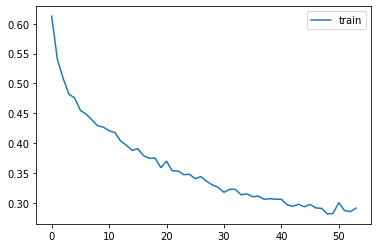

51.478270616630205
53.069529864132015
evaluate augmented :  permutation [0.7873805165290833, 0.7852980494499207, 0.9005791544914246, 0.7127578258514404]


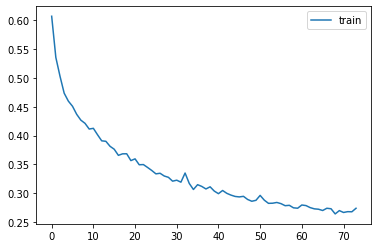

51.478270616630205
65.08534428591683
evaluate augmented :  permutation [0.8950263261795044, 0.7731958627700806, 0.8600386381149292, 0.7116613388061523]


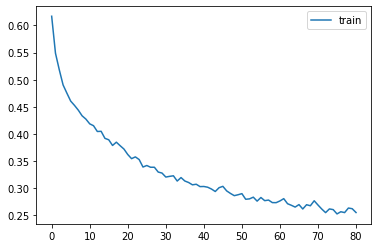

51.478270616630205
55.79902552912551
evaluate augmented :  permutation [0.8563750386238098, 0.7718511819839478, 0.8436293601989746, 0.7158067226409912]


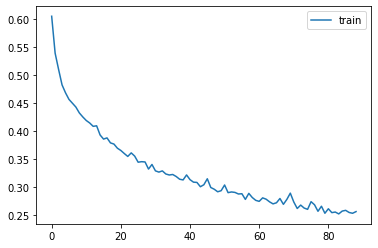

51.478270616630205
48.1435029365334
evaluate augmented :  permutation [0.6856489777565002, 0.7866427898406982, 0.8870656490325928, 0.7190923094749451]


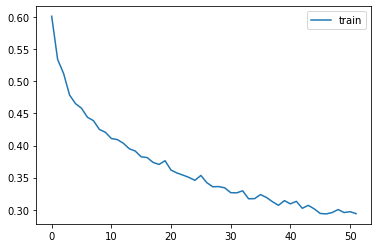

51.478270616630205
63.18615193156145
evaluate augmented :  permutation [0.7780378460884094, 0.7870910167694092, 0.8204632997512817, 0.746268630027771]


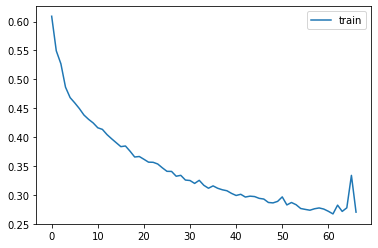

51.478270616630205
94.46966983386
evaluate augmented :  permutation [0.8543012142181396, 0.7929179668426514, 0.8532818555831909, 0.7403684854507446]


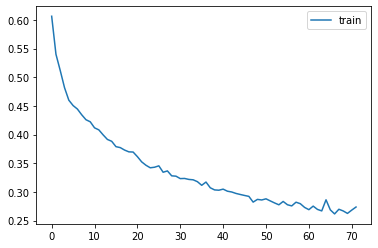

[0.7902286052703857, 0.7799193263053894, 0.7929179668426514, 0.7817122340202332, 0.7852980494499207, 0.7731958627700806, 0.7718511819839478, 0.7866427898406982, 0.7870910167694092, 0.7929179668426514]
[0.8889961242675781, 0.8079150319099426, 0.8532818555831909, 0.8021235466003418, 0.9005791544914246, 0.8600386381149292, 0.8436293601989746, 0.8870656490325928, 0.8204632997512817, 0.8532818555831909]
[0.7229199409484863, 0.741364061832428, 0.7403684854507446, 0.7466307282447815, 0.7127578258514404, 0.7116613388061523, 0.7158067226409912, 0.7190923094749451, 0.746268630027771, 0.7403684854507446]
mean: 0.7841775000095368 -- std: (+/- 0.007085007501260236


In [6]:
# for each technique run tec_len times the model to obtain an average of accuracy and fill the csv table with results
best_lr = 0.001
epoch = 100
batch_s = 128

techniques = ['jitter', 'scale', 'magWarp', 'timeWarp', 'permutation']

line_csv_acc, line_csv_recall, line_csv_precision= [],[],[]
std_accuracy, std_recall, std_precision  = [],[],[]
arr_eda_percentage = []



train_set = np.load('train_set_original.npy',  encoding='ASCII')
train_label = np.load('train_label_original.npy',  encoding='ASCII')
test_set = np.load('test_set.npy',  encoding='ASCII')
test_label = np.load('test_label.npy',  encoding='ASCII')
train_label = train_label.reshape(train_label.shape[0], 1)
test_label = test_label.reshape(test_label.shape[0], 1)


train_set_arr = train_set[2]
test_set_arr = test_set[2]


model = model_network(best_lr)

# ORIGINAL SET
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
history = model.fit(train_set_arr, train_label, epochs=epoch, batch_size= batch_s, shuffle=True, verbose=0, callbacks=[callback])
scores1 = model.evaluate(test_set_arr, test_label, verbose=0)
print("evaluate original: ",scores1)
original_accuracy = scores1[1]
line_csv_acc.append(round(scores1[1]* 100,4))
line_csv_recall.append(round(scores1[2]* 100,4))
line_csv_precision.append(round(scores1[3]* 100,4))
std_accuracy.append(0)
std_recall.append(0)
std_precision.append(0)

pyplot.plot(history.history['loss'], label='train')
pyplot.legend()
pyplot.show()
            
# --------------------------------------------------------------------


for technique in techniques:
    print(technique)
    
    recall_original = 0
    accuracies, recalls, precisions = [],[],[]
    
    tec_len = 10
    
# loop tec_len times to get the average of a tecnique
    for avg_t in range(0, tec_len):
        train_set = np.load('train_set_original.npy',  encoding='ASCII')
        train_label = np.load('train_label_original.npy',  encoding='ASCII')
        test_set = np.load('test_set.npy',  encoding='ASCII')
        test_label = np.load('test_label.npy',  encoding='ASCII')
        train_label = train_label.reshape(train_label.shape[0], 1)
        test_label = test_label.reshape(test_label.shape[0], 1)

        
        train_set_arr_augment, label_set_augmented = augment_data(train_set[2], train_label, technique)
        
        test_set_arr = test_set[2]
        model = model_network(best_lr)

        # AUGMENTATION
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
        history = model.fit(train_set_arr_augment, label_set_augmented, epochs=epoch, batch_size= batch_s, shuffle=True,verbose=0, callbacks = [callback])
        scores2 = model.evaluate(test_set_arr, test_label,verbose=0)
        #     --------------------------------------------------------------------
        print("evaluate augmented : ", technique, scores2)

        accuracies.append(scores2[1])
        recalls.append(scores2[2])
        precisions.append(scores2[3])

        
        pyplot.plot(history.history['loss'], label='train')
        pyplot.legend()
        pyplot.show()
 

    line_csv_acc.append(round(np.mean(accuracies)* 100,4))
    line_csv_recall.append(round(np.mean(recalls)* 100,4))
    line_csv_precision.append(round(np.mean(precisions)* 100,4))
    std_accuracy.append(round(np.std(accuracies)* 100,4))
    std_recall.append(round(np.std(recalls)* 100,4))
    std_precision.append(round(np.std(precisions)* 100,4))
    print(accuracies)
    print(recalls)
    print(precisions)
    print("mean: {} -- std: (+/- {}".format(np.mean(accuracies), np.std(accuracies)))

    arr_eda_percentage.append(round((np.mean(accuracies) - original_accuracy) * 100, 4))



line_csv_acc.insert(0, 'ACC')
std_accuracy.insert(0, 'STD ACCURACY')
line_csv_recall.insert(0, 'RECALL')
std_recall.insert(0, 'STD RECALL')
line_csv_precision.insert(0, 'PRECISION')
std_precision.insert(0, 'STD PRECISION')

header = ['sensor', 'baseline', 'jitter', 'scale', 'magWarp', 'timeWarp', 'permutation']

with open('table_accuracy_ACC.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerow(line_csv_acc)
    writer.writerow(std_accuracy)
    writer.writerow(line_csv_recall)
    writer.writerow(std_recall)
    writer.writerow(line_csv_precision)
    writer.writerow(std_precision)

    writer.writerow([])
    arr_eda_percentage.insert(0, 0)
    arr_eda_percentage.insert(0, 'ACC')
    writer.writerow(arr_eda_percentage)

